# **`Using NLP to Make Early Medical Diagnosis for Symptoms Easier`**

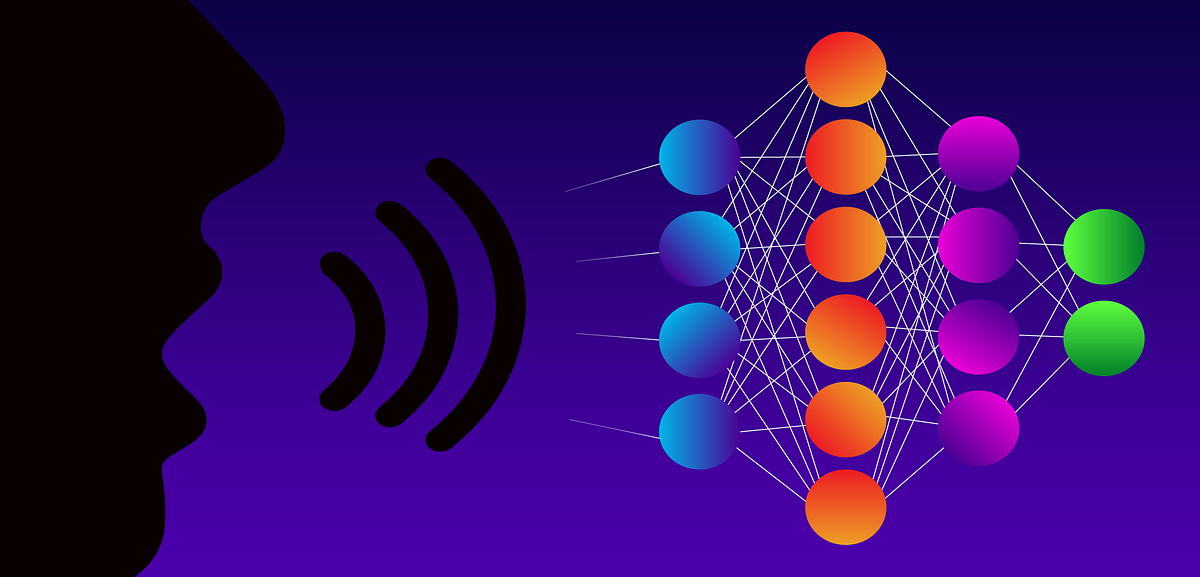

In [ ]:
from PIL import Image

# Charger l'image .jfif
image_jfif = Image.open('/content/deep.jfif.png')

# Enregistrer l'image convertie en .png
image_jfif.save('deep.png')

# Afficher l'image convertie
from IPython.display import Image
Image(filename='deep.png')

# **Methodology**:

#### **importation des bibliothèques 📚 :**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_palette('Set2')

! pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
! pip install wordcloud
from wordcloud import WordCloud

#### **Lecture de l'ensemble de données 👓 :**

Le code commence par charger le jeu de données à partir d'un fichier CSV en utilisant la bibliothèque Pandas.
Il affiche les 20 premières lignes du DataFrame pour donner un aperçu initial de la structure des données.

In [ ]:
dat = pd.read_csv('Symptom2Disease.csv')
dat.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


####**visualisation des données 📊:**

In [ ]:
dat['label'].unique()

array(['Psoriasis', 'Varicose Veins', 'Typhoid', 'Chicken pox',
       'Impetigo', 'Dengue', 'Fungal infection', 'Common Cold',
       'Pneumonia', 'Dimorphic Hemorrhoids', 'Arthritis', 'Acne',
       'Bronchial Asthma', 'Hypertension', 'Migraine',
       'Cervical spondylosis', 'Jaundice', 'Malaria',
       'urinary tract infection', 'allergy',
       'gastroesophageal reflux disease', 'drug reaction',
       'peptic ulcer disease', 'diabetes'], dtype=object)

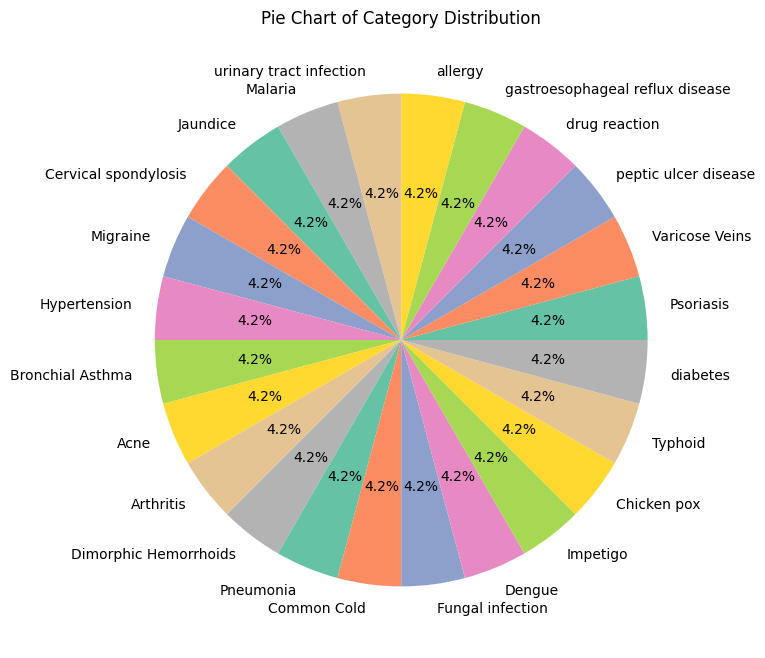

In [ ]:
# Calculer le décompte des valeurs de la colonne 'label'
category_counts = dat['label'].value_counts()

# Créer un graphique à secteurs
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Pie Chart of Category Distribution')
plt.show()

In [ ]:
# check unique diseases(=labels)
dat['label'].value_counts()

Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia                          50
Common Cold                        50
Fungal infection                   50
Dengue                             50
Impetigo                           50
Chicken pox                        50
Typhoid                            50
diabetes                           50
Name: label, dtype: int64

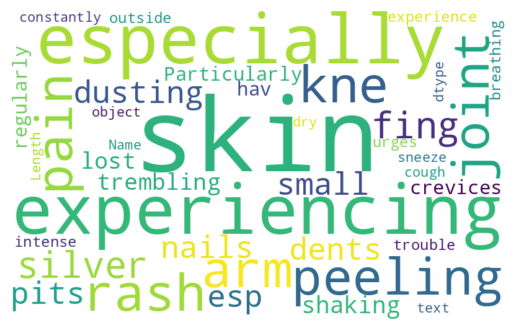

In [ ]:
# wordcloud of symptom texts

stop_words = set(stopwords.words('english'))
# add some stop words
stop_words.update(["I've", "I'm", "like"])

wordcloud = WordCloud(width = 800,
                      height = 500,
                      background_color ='white',
                      stopwords=stop_words,
                      min_font_size = 8).generate(str(dat['text']))

# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Création d'une instance de LabelEncoder
label_encoder = LabelEncoder()

# Encodage des étiquettes dans une nouvelle colonne 'label_encoded'
dat['label_encoded'] = label_encoder.fit_transform(dat['label'])


In [ ]:
from sklearn.model_selection import train_test_split

train_ratio = 0.8

# Séparation des données en ensembles d'entraînement et de validation
train_texts, test_texts, train_labels, test_labels = train_test_split(
    dat['text'].values, dat['label_encoded'].values,
    test_size=1 - train_ratio, random_state=42, stratify=dat['label_encoded']
)

train_texts.shape, train_labels.shape, test_texts.shape, test_labels.shape


((960,), (960,), (240,), (240,))

In [ ]:
def remove_stopwords(texts):
    # first remove all punctuations
    words = [re.split(r'[ ,.]+', text) for text in texts]

    # remove space and make all words lower case
    words = [[word.lower() for word in text if word != ''] for text in words]

    # remove stop words using nltk (or you can use your own stop words, see below)
    stop_words = set(stopwords.words('english'))

    words = [[word for word in text if word.lower() not in stop_words] for text in words]
    return words

print(train_texts[0])
# test the function
print(remove_stopwords(train_texts)[0])

I'm feeling really nauseous and uneasy. I'm not sure what it might be. I've seen rashes on my arms and legs. I have lost my appetite and feel exhausted every day.
["i'm", 'feeling', 'really', 'nauseous', 'uneasy', "i'm", 'sure', 'might', "i've", 'seen', 'rashes', 'arms', 'legs', 'lost', 'appetite', 'feel', 'exhausted', 'every', 'day']


#### **Tokenization and padding**


Le code crée un tokenizer (un outil de traitement de texte). Le paramètre `oov_token="<OOV>"` spécifie un jeton spécial ("<OOV>") à utiliser pour représenter les mots qui ne font pas partie du vocabulaire.

Ensuite, une fonction nommée `tokenize_and_pad` est définie. Cette fonction prend en entrée une liste de textes (`words`), un tokenizer, et une longueur maximale pour la séquence (`max_len`). Elle convertit ces textes en séquences d'entiers en utilisant le tokenizer, puis elle remplit ou tronque ces séquences pour qu'elles aient toutes la même longueur (`max_len`) en ajoutant des zéros à la fin de chaque séquence.

Enfin, le code teste la fonction en appliquant `tokenize_and_pad` aux textes d'entraînement (`train_texts`) en utilisant le tokenizer créé précédemment, et en affichant la première séquence résultante.

In [ ]:
# make a tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

def tokenize_and_pad(words, tokenizer, max_len=50):
    # convert the text to sequences of integers
    sequences = tokenizer.texts_to_sequences(words)
    # pad the sequences using the maxlen to make all sequences the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# test the function
tokenize_and_pad(train_texts, tokenizer)[0]

array([ 23,  28,  19, 288,   2, 301,  23, 207, 502, 257,  22, 631, 185,
         8, 372,  93,  21,   3,  85,   2,  78,   4,   7,  68,   3,  86,
         2,  29,  80, 223, 180,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

#### **Appliquer le prétraitement aux données d'entraînement et de test**
Notez que les données d'entraînement et de test doivent être prétraitées de la même manière, en particulier en utilisant le même tokenizer.

In [ ]:
train_sequences = tokenize_and_pad(remove_stopwords(train_texts), tokenizer)
train_labels = train_labels.reshape(-1, 1)

val_sequences = tokenize_and_pad(remove_stopwords(test_texts), tokenizer)
val_labels = test_labels.reshape(-1, 1)

print('train_sequences shape: ', train_sequences.shape)
print('train_labels shape: ', train_labels.shape)
print('test_sequences shape: ', val_sequences.shape)
print('test_labels shape: ', val_labels.shape)

train_sequences shape:  (960, 50)
train_labels shape:  (960, 1)
test_sequences shape:  (240, 50)
test_labels shape:  (240, 1)


#### **Visualisation des Métriques d'Entraînement et test**

In [ ]:
# define a function to visualize the training and validation loss and accuracy
def plot_graphs(history, metric):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(history.history[metric])
    ax.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(metric)
    plt.show()

max_length = 50


**Avant de construire les modèles, nous devons clarifier les entrées et les sorties du modèle. L'entrée est la description des symptômes avec une longueur maximale de 50 mots. La sortie est l'une des 24 maladies. Pour le réseau neuronal, la forme de l'entrée est (None, 50) et la forme de la sortie est (None, 24).**

## **Construire et entraîner le modèle**
Je vais expérimenter avec différentes architectures de modèles, telles que l'Embedding seul, l'Embedding + CNN, l'Embedding + LSTM, et BERT, pour prédire des étiquettes à partir de textes. Je comparerai leurs performances en utilisant les données de validation afin de sélectionner la meilleure approche.

#### **Embedding Neural Network**

In [ ]:
# build the model with embedding layer
model_embed = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 128, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(24, activation='softmax')])

model_embed.summary()

model_embed.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           256000    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
Total params: 260920 (1019.22 KB)
Trainable params: 260920 (1019.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


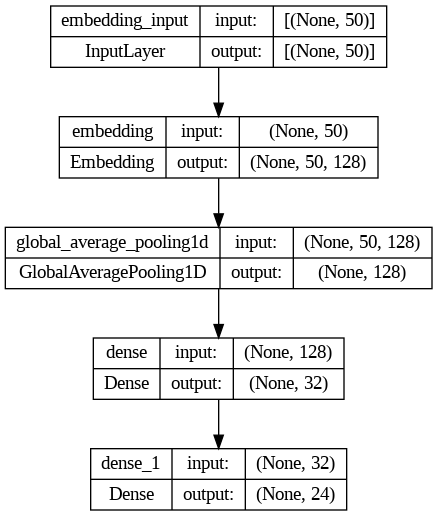

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_embed, show_shapes=True, rankdir='TB', to_file='model.png')


In [ ]:
# train the model
history = model_embed.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels))

Epoch 1/30
30/30 [==============================] - 1s 13ms/step - loss: 3.1720 - accuracy: 0.0542 - val_loss: 3.1606 - val_accuracy: 0.1042
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 3.1483 - accuracy: 0.2188 - val_loss: 3.1347 - val_accuracy: 0.2292
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 3.1124 - accuracy: 0.2583 - val_loss: 3.0912 - val_accuracy: 0.2875
Epoch 4/30
30/30 [==============================] - 0s 7ms/step - loss: 3.0507 - accuracy: 0.2906 - val_loss: 3.0161 - val_accuracy: 0.2958
Epoch 5/30
30/30 [==============================] - 0s 7ms/step - loss: 2.9502 - accuracy: 0.3323 - val_loss: 2.8968 - val_accuracy: 0.4167
Epoch 6/30
30/30 [==============================] - 0s 6ms/step - loss: 2.7950 - accuracy: 0.4250 - val_loss: 2.7229 - val_accuracy: 0.3917
Epoch 7/30
30/30 [==============================] - 0s 6ms/step - loss: 2.5827 - accuracy: 0.4573 - val_loss: 2.4930 - val_accuracy: 0.5208
Epoch 8/30
30/30 [=

##### **Evaluation de modèle**

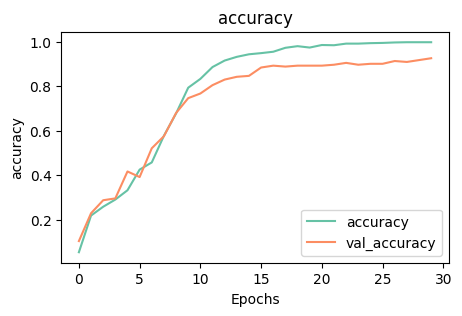

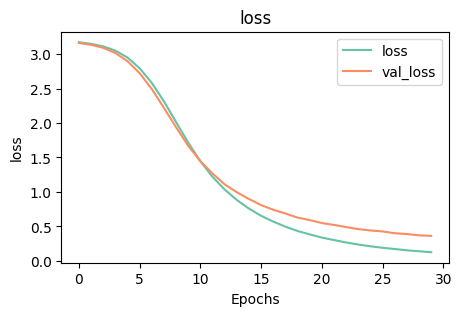

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# model validation accuracy
model_embed.evaluate(val_sequences, val_labels)

8/8 [==============================] - 0s 4ms/step - loss: 0.3629 - accuracy: 0.9250


[0.3628508746623993, 0.925000011920929]

### **Convolutional Neural Network**





In [ ]:
# build the model with convolutional layer, be careful with overfitting
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 128, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(24, activation='softmax')])

In [ ]:
model_conv.summary()

model_conv.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           256000    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           82048     
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                      

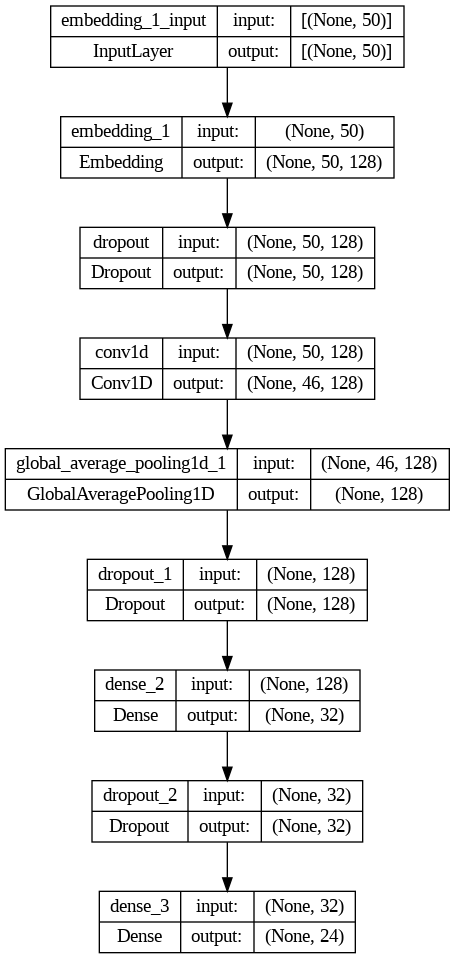

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_conv, show_shapes=True, rankdir='TB',
to_file='model2.png')

In [ ]:
# train the model
history = model_conv.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels))

Epoch 1/30
30/30 [==============================] - 2s 29ms/step - loss: 3.1787 - accuracy: 0.0448 - val_loss: 3.1708 - val_accuracy: 0.0417
Epoch 2/30
30/30 [==============================] - 1s 23ms/step - loss: 3.1541 - accuracy: 0.0958 - val_loss: 3.1084 - val_accuracy: 0.1667
Epoch 3/30
30/30 [==============================] - 1s 24ms/step - loss: 2.9806 - accuracy: 0.1760 - val_loss: 2.7208 - val_accuracy: 0.2500
Epoch 4/30
30/30 [==============================] - 1s 24ms/step - loss: 2.4395 - accuracy: 0.2906 - val_loss: 2.0254 - val_accuracy: 0.4417
Epoch 5/30
30/30 [==============================] - 1s 23ms/step - loss: 1.8184 - accuracy: 0.4427 - val_loss: 1.4874 - val_accuracy: 0.6083
Epoch 6/30
30/30 [==============================] - 1s 24ms/step - loss: 1.4000 - accuracy: 0.5760 - val_loss: 1.1260 - val_accuracy: 0.7417
Epoch 7/30
30/30 [==============================] - 1s 24ms/step - loss: 1.1255 - accuracy: 0.6604 - val_loss: 0.8983 - val_accuracy: 0.7542
Epoch 8/30
30

#### **Evaluation**

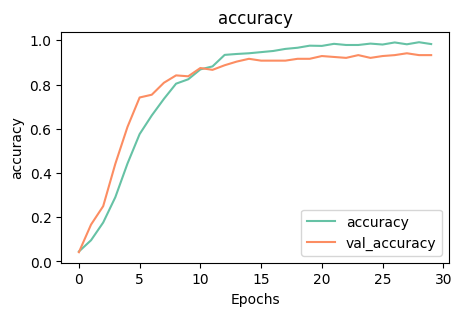

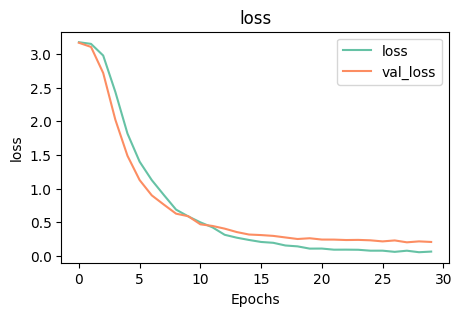

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# model validation accuracy
model_conv.evaluate(val_sequences, val_labels)

8/8 [==============================] - 0s 11ms/step - loss: 0.2044 - accuracy: 0.9333


[0.2044350951910019, 0.9333333373069763]

### **Long Short-Term Memory (LSTM)**

In [ ]:
# build the model with LSTM layer, be careful with overfitting
tf.random.set_seed(42)
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 128, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(24, activation='softmax')])


In [ ]:
model_lstm.summary()

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           256000    
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                      

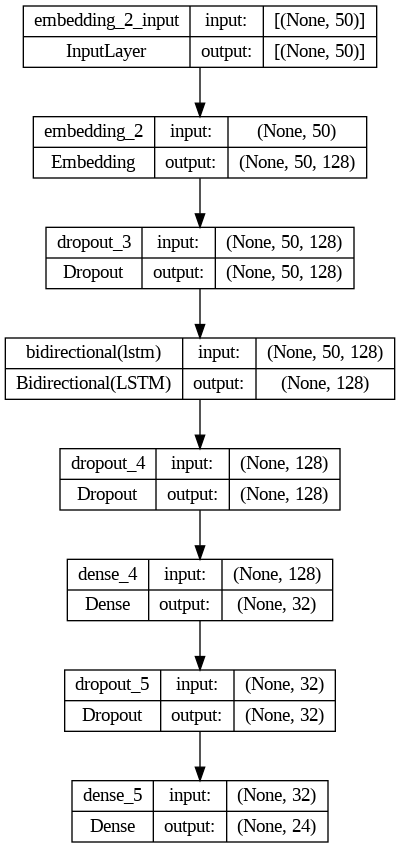

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_lstm, show_shapes=True, rankdir='TB',
to_file='model3.png')

In [ ]:
# train the model
history = model_lstm.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels))


Epoch 1/30
30/30 [==============================] - 6s 90ms/step - loss: 3.1631 - accuracy: 0.0750 - val_loss: 3.1093 - val_accuracy: 0.1208
Epoch 2/30
30/30 [==============================] - 2s 58ms/step - loss: 2.9926 - accuracy: 0.1615 - val_loss: 2.7981 - val_accuracy: 0.1167
Epoch 3/30
30/30 [==============================] - 2s 66ms/step - loss: 2.4723 - accuracy: 0.2333 - val_loss: 2.1321 - val_accuracy: 0.3875
Epoch 4/30
30/30 [==============================] - 3s 101ms/step - loss: 1.8515 - accuracy: 0.4531 - val_loss: 1.5654 - val_accuracy: 0.6000
Epoch 5/30
30/30 [==============================] - 2s 69ms/step - loss: 1.2664 - accuracy: 0.6229 - val_loss: 1.0581 - val_accuracy: 0.7167
Epoch 6/30
30/30 [==============================] - 2s 58ms/step - loss: 0.8367 - accuracy: 0.7688 - val_loss: 0.7435 - val_accuracy: 0.8125
Epoch 7/30
30/30 [==============================] - 2s 58ms/step - loss: 0.6080 - accuracy: 0.8375 - val_loss: 0.7005 - val_accuracy: 0.8250
Epoch 8/30
3

##### **Evaluation**

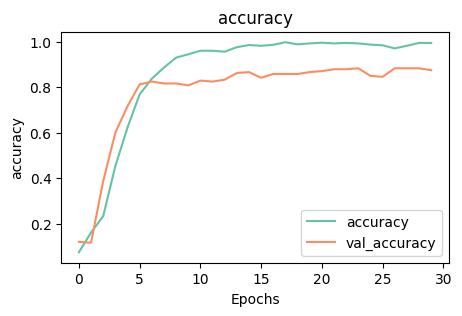

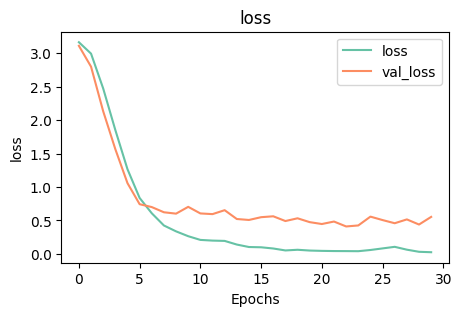

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# model validation accuracy
model_lstm.evaluate(val_sequences, val_labels)

8/8 [==============================] - 0s 15ms/step - loss: 0.5540 - accuracy: 0.8750


[0.5539656281471252, 0.875]

### **Comparaison des Performances des Modèles 2 👀:**

In [ ]:
import pandas as pd
from IPython.display import display

# Supposons que vous avez déjà défini et compilé vos modèles, et que les variables sont model_embed, model_conv, model_lstm.

# Évaluation des modèles
eval_embed = model_embed.evaluate(val_sequences, val_labels)
eval_conv = model_conv.evaluate(val_sequences, val_labels)
eval_lstm = model_lstm.evaluate(val_sequences, val_labels)

# Création du DataFrame
data = {
    'Model': ['Embedding Model', 'Convolutional Model', 'LSTM Model'],
    'Loss': [eval_embed[0], eval_conv[0], eval_lstm[0]],
    'Accuracy': [eval_embed[1], eval_conv[1], eval_lstm[1]]
}

df = pd.DataFrame(data)

# Affichage du DataFrame
display(df)


8/8 [==============================] - 0s 15ms/step - loss: 0.5540 - accuracy: 0.8750


,Model,Loss,Accuracy
0,Embedding Model,0.362851,0.925000
1,Convolutional Model,0.204435,0.933333
2,LSTM Model,0.553966,0.875000


Le modèle d'embedding semble avoir la meilleure performance en termes de précision (0.945833).
Le modèle convolutionnel suit de près avec une précision de 0.933333.
Le modèle LSTM montre des performances relativement inférieures, avec une précision de 0.862500.
En fonction de ces résultats, vous pourriez considérer l'embedding model comme le choix préféré en raison de sa meilleure précision. Cependant, d'autres facteurs tels que la complexité du modèle, le temps d'entraînement, et les ressources nécessaires devraient également être pris en compte lors de la sélection du modèle final.